In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/capstor/users/cscs/xyixuan/PDM/')

In [3]:
from src.verbatim_eval.rouge_ttr import eval_rouge_ttr
from src.verbatim_eval.rouge_ttr import log_metric, log_metrics
from src.verbatim_eval.utils import load_inference_data
import numpy as np

/users/xyixuan/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
base_path = "/iopsstor/scratch/cscs/xyixuan/experiment"
# repetitions  = np.array([1, 2, 3, 4, 8, 16, 24, 32, 48, 64, 96, 128])
repetitions = np.array([0, 128, 256, 512, 1024, 2048])

In [8]:
goldfish_res_greedy = eval_rouge_ttr(
    base_path, 
    experiments=[
        # "llama_1.5B_Sparse_Gutenberg_Standard_GBS_60",
        # "llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60",
        # "llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_1984000",
        # "llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_1984000",
        # "llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_2023680",
        # "llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_3968000",
        # "llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_3968000",
        # "llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_7936000",
        # "llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_2380800",
        "llama_1.5B_Sparse_Gutenberg_K_50_H_50_GBS_60_SEQ_11971350",
        "llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_11971350",
        "llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_11971350"
    ], 
    repetitions=repetitions,
    len_suffix=500,
    policy='greedy'
)

Processing repetition set 0:   0%|          | 0/6 [00:00<?, ?it/s]

Processing repetition set 2048: 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]
Generating train split: 500 examples [00:00, 13677.82 examples/s]]
Calculating metrics for rep=0 (num_proc=50): 100%|██████████| 500/500 [00:00<00:00, 632.95 examples/s]
Generating train split: 500 examples [00:00, 13378.28 examples/s]  1.35s/it]
Calculating metrics for rep=128 (num_proc=50): 100%|██████████| 500/500 [00:00<00:00, 635.08 examples/s]
Generating train split: 500 examples [00:00, 13984.93 examples/s]  1.33s/it]
Calculating metrics for rep=256 (num_proc=50): 100%|██████████| 500/500 [00:00<00:00, 637.08 examples/s]
Generating train split: 500 examples [00:00, 14162.48 examples/s]  1.33s/it]
Calculating metrics for rep=512 (num_proc=50): 100%|██████████| 500/500 [00:00<00:00, 641.29 examples/s]
Generating train split: 500 examples [00:00, 14331.76 examples/s],  1.40s/it]
Calculating metrics for rep=1024 (num_proc=50): 100%|██████████| 500/500 [00:00<00:00, 635.61 examples/s]
Generating train split

In [9]:
log_metrics(
    goldfish_res_greedy
)


=== Summary for Experiment: llama_1.5B_Sparse_Gutenberg_K_50_H_50_GBS_60_SEQ_11971350 ===
  Repetition   0
    NLL        | Mean = 0.460, Std = 0.071
    Rouge-L    | Mean = 0.159, Std = 0.022
    TTR_ref    | Mean = 0.541, Std = 0.050
    TTR_gen    | Mean = 0.558, Std = 0.036
  Repetition 128
    NLL        | Mean = 0.450, Std = 0.069
    Rouge-L    | Mean = 0.180, Std = 0.046
    TTR_ref    | Mean = 0.540, Std = 0.057
    TTR_gen    | Mean = 0.551, Std = 0.058
  Repetition 256
    NLL        | Mean = 0.447, Std = 0.066
    Rouge-L    | Mean = 0.182, Std = 0.045
    TTR_ref    | Mean = 0.539, Std = 0.052
    TTR_gen    | Mean = 0.553, Std = 0.046
  Repetition 512
    NLL        | Mean = 0.438, Std = 0.068
    Rouge-L    | Mean = 0.183, Std = 0.045
    TTR_ref    | Mean = 0.539, Std = 0.045
    TTR_gen    | Mean = 0.554, Std = 0.040
  Repetition 1024
    NLL        | Mean = 0.433, Std = 0.061
    Rouge-L    | Mean = 0.187, Std = 0.052
    TTR_ref    | Mean = 0.539, Std = 0.046
    TT

/users/xyixuan/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/users/xyixuan/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/users/xyixuan/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/users/xyixuan/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/users/xyixuan/miniconda3/lib/python3.12/site-packages/seab

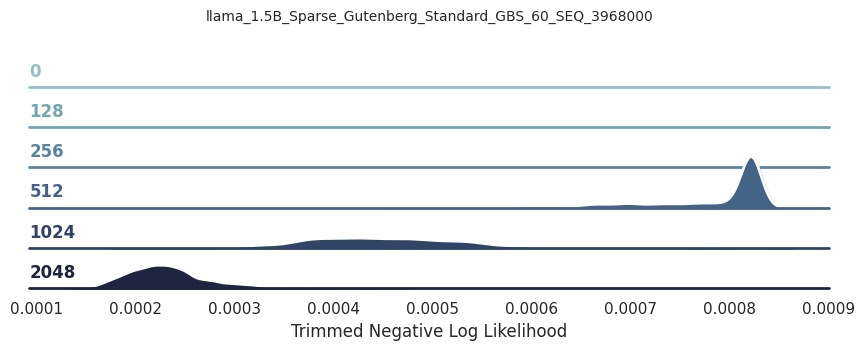

In [18]:
from src.vis.distributions import plot_nll_distributions_ridge

plot_nll_distributions_ridge(
    results_dict=goldfish_res_greedy,
    model_key="llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_3968000",
    upper_quantile=0.4,
)

/users/xyixuan/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/users/xyixuan/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/users/xyixuan/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/users/xyixuan/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwar

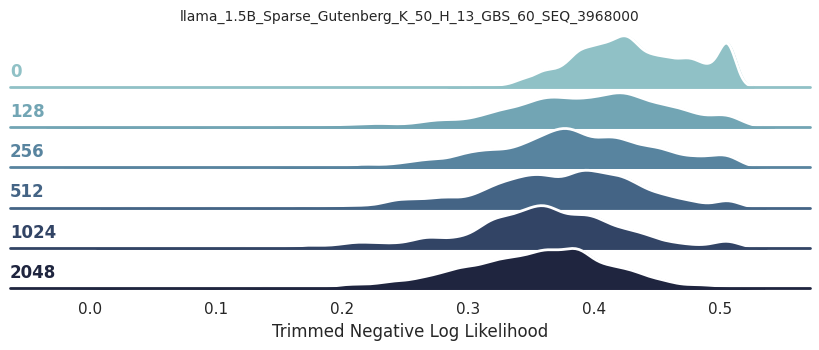

In [17]:
from src.vis.distributions import plot_nll_distributions_ridge

plot_nll_distributions_ridge(
    results_dict=goldfish_res_greedy,
    model_key="llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_3968000",
    upper_quantile=0.96,
)

In [15]:
log_metric(
    results=goldfish_res_greedy,
    metric='TTR_gen',
)


=== Repetition 0 TTR_gen ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_3968000  : Mean = 0.558 | Std = 0.034
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_3968000   : Mean = 0.556 | Std = 0.043

=== Repetition 128 TTR_gen ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_3968000  : Mean = 0.554 | Std = 0.049
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_3968000   : Mean = 0.541 | Std = 0.055

=== Repetition 256 TTR_gen ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_3968000  : Mean = 0.553 | Std = 0.044
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_3968000   : Mean = 0.541 | Std = 0.053

=== Repetition 512 TTR_gen ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_3968000  : Mean = 0.555 | Std = 0.035
  llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_3968000   : Mean = 0.539 | Std = 0.045

=== Repetition 1024 TTR_gen ===
  llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60_SEQ_3968000  : Mean = 0.551 | Std = 0.044
  llama_1.5B_Sparse_Gutenberg_Standard_G

In [23]:
from src.vis.correlations import plot_spearman_correlation, plot_pearson_correlation

Pearson Correlation Tests between NLL and TTR_gen:

Repetition 0:
r = 0.6095
p-value = 0.0000

Repetition 128:
r = 0.0361
p-value = 0.4202

Repetition 256:
r = 0.0127
p-value = 0.7775

Repetition 512:
r = 0.0678
p-value = 0.1300

Repetition 1024:
r = 0.1346
p-value = 0.0026

Repetition 2048:
r = 0.1836
p-value = 0.0000


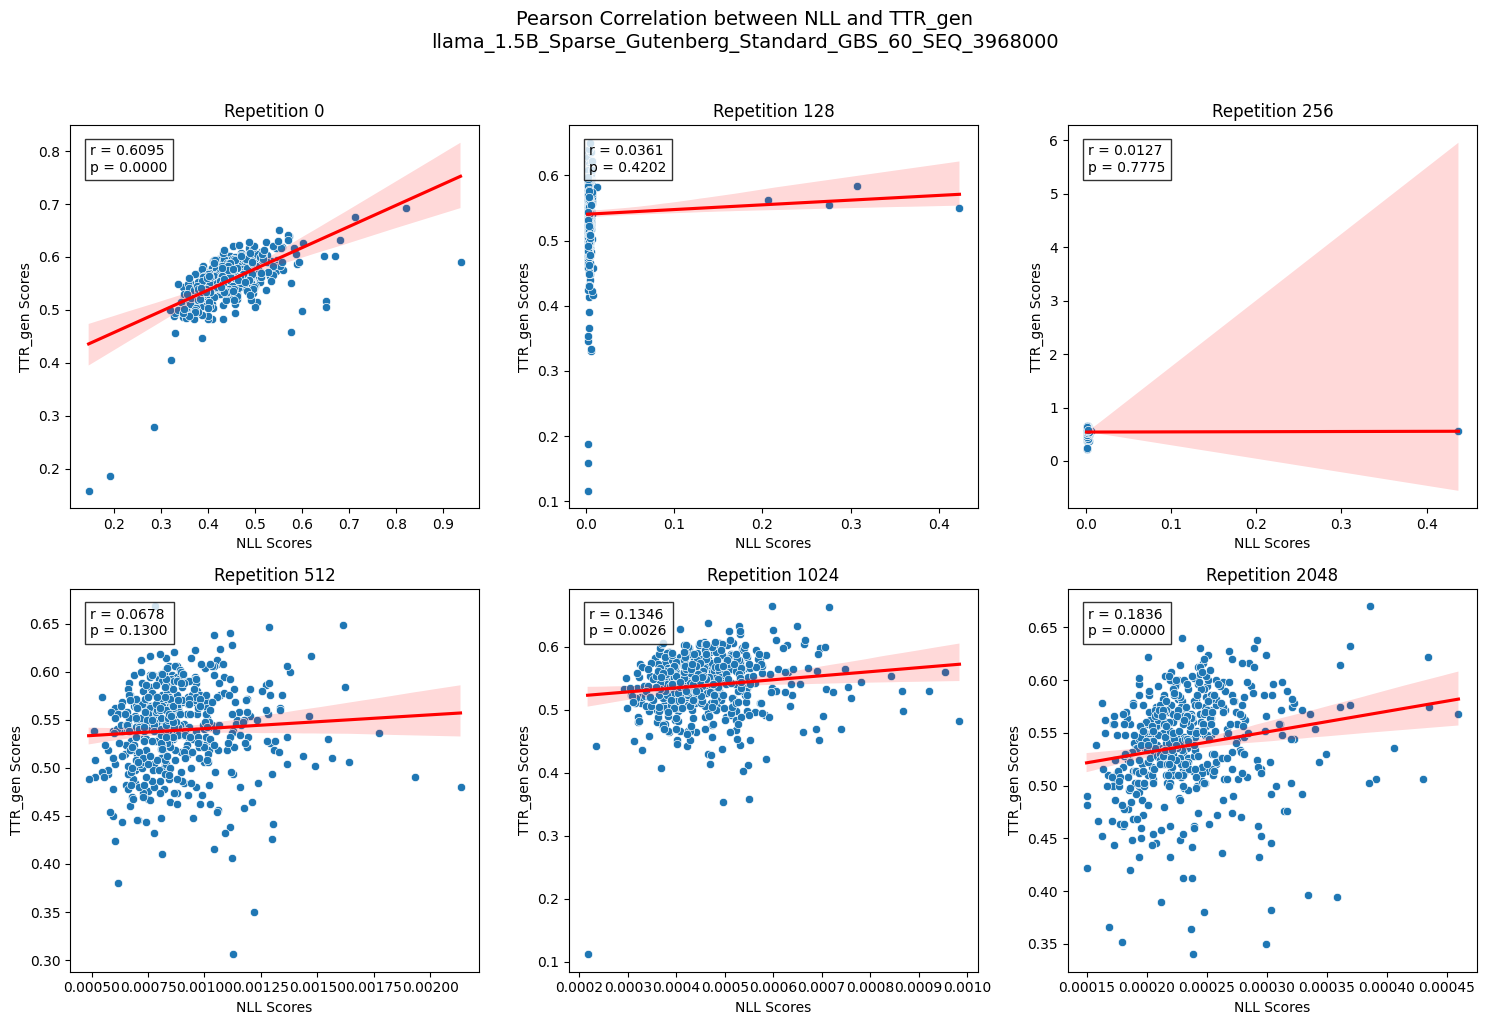

In [24]:
plot_pearson_correlation(
    result=goldfish_res_greedy,
    expr='llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_3968000',
    metric1='NLL',
    metric2='TTR_gen',
)

Spearman Correlation Tests between NLL and TTR_gen:

Repetition 0:
rho = 0.6054
p-value = 0.0000

Repetition 128:
rho = 0.1320
p-value = 0.0031

Repetition 256:
rho = 0.1144
p-value = 0.0105

Repetition 512:
rho = 0.1361
p-value = 0.0023

Repetition 1024:
rho = 0.1594
p-value = 0.0003

Repetition 2048:
rho = 0.2589
p-value = 0.0000


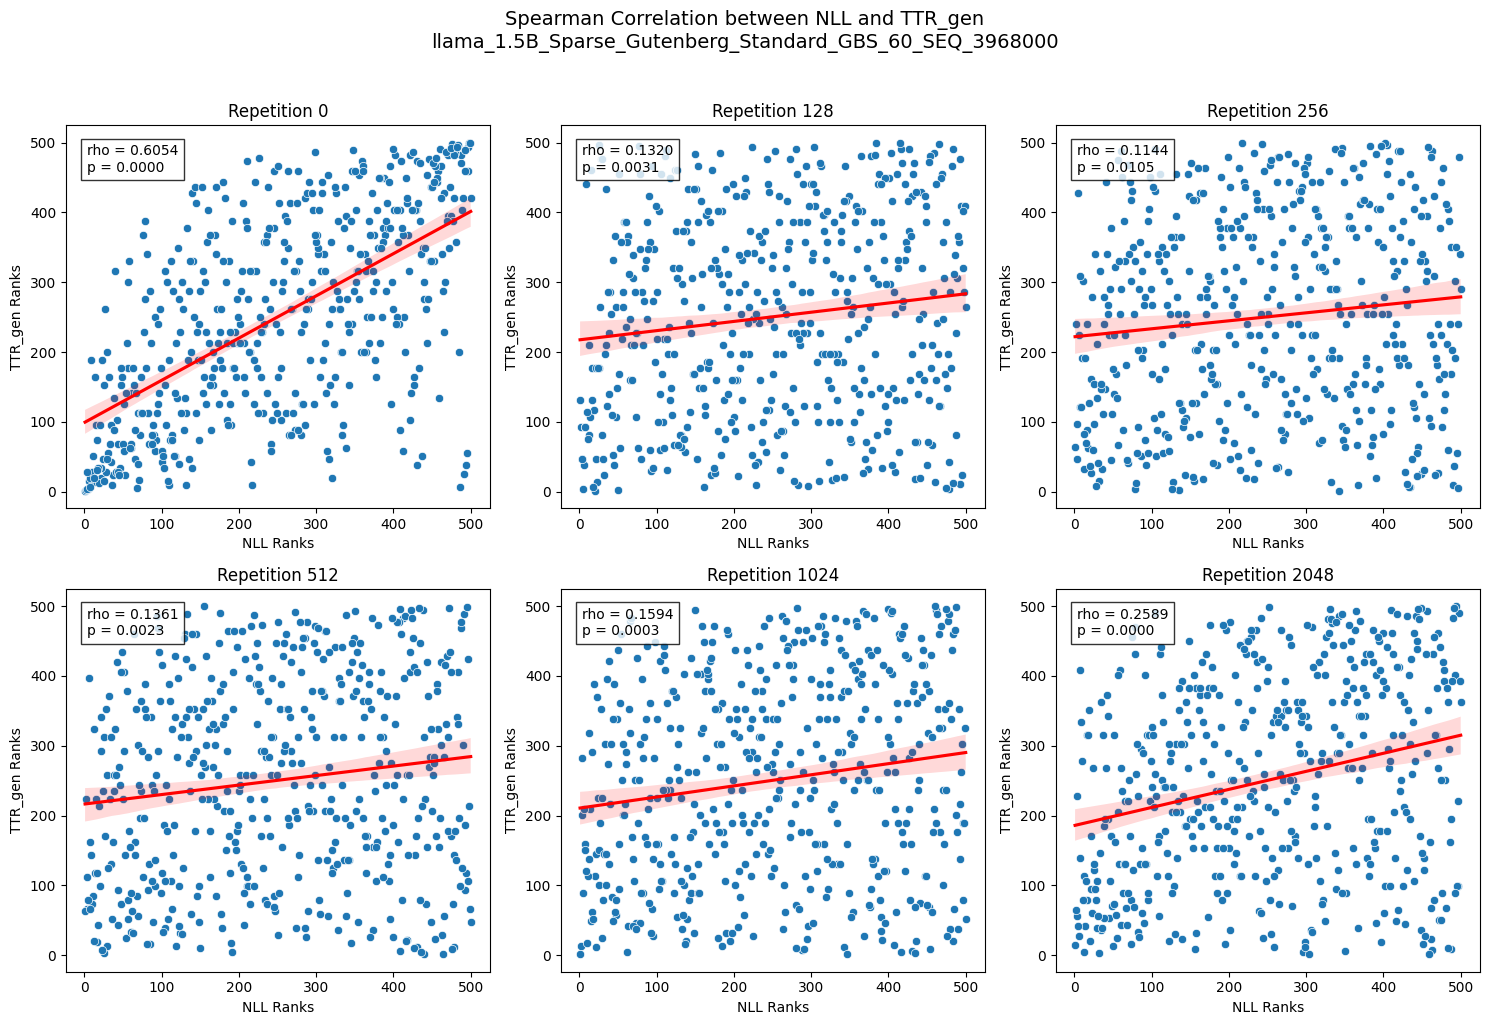

In [22]:
plot_spearman_correlation(
    result=goldfish_res_greedy,
    expr='llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_3968000',
    metric1='NLL',
    metric2='TTR_gen',
)

In [11]:
from src.verbatim_eval.utils import find_top_quantile_indices

In [12]:
find_top_quantile_indices(
    metric_1_scores=goldfish_res_greedy['llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_11971350'][2048]['Rouge-L']['scores'],
    metric_2_scores=goldfish_res_greedy['llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_11971350'][2048]['TTR_gen']['scores'],
    q=0.1,
)

[23, 40, 102, 153, 254, 277]

In [15]:
import matplotlib.pyplot as plt

def plot_ttr_dists(
    goldfish_res: dict,
    repetitions: list[int],
    metric: str,
):
    """
    Plot the distributions of TTR (Type-Token Ratio) scores for multiple repetitions.

    Parameters
    ----------
    expr : str
        An identifier or label for the experiment/model grouping.
    repetitions : list[int]
        A list of repetition indices (e.g., [1, 2, 3, 4]).
    goldfish_res : dict
        Nested dict of model evaluation results. For example:
            goldfish_res[model_name][rep]['TTR_gen']['scores'] = np.array(...)
            goldfish_res[model_name][rep]['TTR_ref']['scores'] = np.array(...)
    """
    n_reps = len(repetitions)
    
    # Decide on subplot arrangement: up to 3 columns, rows as needed
    n_cols = min(3, n_reps)  
    n_rows = (n_reps + n_cols - 1) // n_cols  # "ceiling" division

    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    fig.suptitle(f"{metric} Distributions")

    # If multiple rows, flatten axes to 1D for easy indexing
    if n_rows > 1:
        axes = axes.ravel()

    # Plot each repetition
    for idx, rep in enumerate(repetitions):
        # For example, we have two model outputs + reference:
        #   model1 = "llama_1.5B_Sparse_Gutenberg_Standard_GBS_60"
        #   model2 = "llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60"
        # We assume you want TTR_gen from both, and TTR_ref from the second.
        if metric == "TTR":
            # arr1 = goldfish_res["llama_1.5B_Sparse_Gutenberg_Standard_GBS_60"][rep]["TTR_gen"]["scores"]
            # arr2 = goldfish_res["llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60"][rep]["TTR_gen"]["scores"]
            # arr3 = goldfish_res["llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60"][rep]["TTR_ref"]["scores"]

            # ax = axes[idx]
            
            # # Plot histograms
            # ax.hist(arr1, bins=30, alpha=0.5, label='Standard TTR_gen')
            # ax.hist(arr2, bins=30, alpha=0.5, label='Goldfish TTR_gen')
            # ax.hist(arr3, bins=30, alpha=0.5, label='Reference TTR_ref')

            arr1 = goldfish_res["llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_11971350"][rep]["TTR_gen"]["scores"]
            arr2 = goldfish_res["llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_11971350"][rep]["TTR_ref"]["scores"]

            ax = axes[idx]
            
            # Plot histograms
            ax.hist(arr1, bins=30, alpha=0.5, label='Standard TTR_gen')
            ax.hist(arr2, bins=30, alpha=0.5, label='Reference TTR_ref')

            ax.set_xlabel("TTR Score")

        elif metric == "Rouge-L":
            # arr1 = goldfish_res["llama_1.5B_Sparse_Gutenberg_Standard_GBS_60"][rep]["Rouge-L"]["scores"]
            # arr2 = goldfish_res["llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60"][rep]["Rouge-L"]["scores"]

            # ax = axes[idx]
            
            # # Plot histograms
            # ax.hist(arr1, bins=30, alpha=0.5, label='Standard Rouge-L')
            # ax.hist(arr2, bins=30, alpha=0.5, label='Goldfish Rouge-L')

            arr1 = goldfish_res["llama_1.5B_Sparse_Gutenberg_Standard_GBS_60_SEQ_11971350"][rep]["Rouge-L"]["scores"]
            ax = axes[idx]
            ax.hist(arr1, bins=30, alpha=0.5, label='Standard Rouge-L')

            ax.set_xlabel("Rouge-L Score")
            ax.set_xlim(0, 1)  # Set y-axis limit to 500
            ax.set_yscale('log')

        else:
            raise ValueError(f"Unknown metric: {metric}, available options: 'TTR', 'Rouge-L'")

        ax.set_ylabel("Frequency")
        ax.set_title(f"Rep {rep}")
        ax.legend()
        ax.grid(axis='y', alpha=0.75)
        # Example of setting log scale on Y-axis:
        # ax.set_yscale('log')

    # Remove any unused subplots (e.g., if n_reps < n_rows*n_cols)
    for idx in range(n_reps, n_rows * n_cols):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()


In [18]:
plot_ttr_dists(goldfish_res_greedy, repetitions_2048, metric='TTR')

NameError: name 'plot_ttr_dists' is not defined

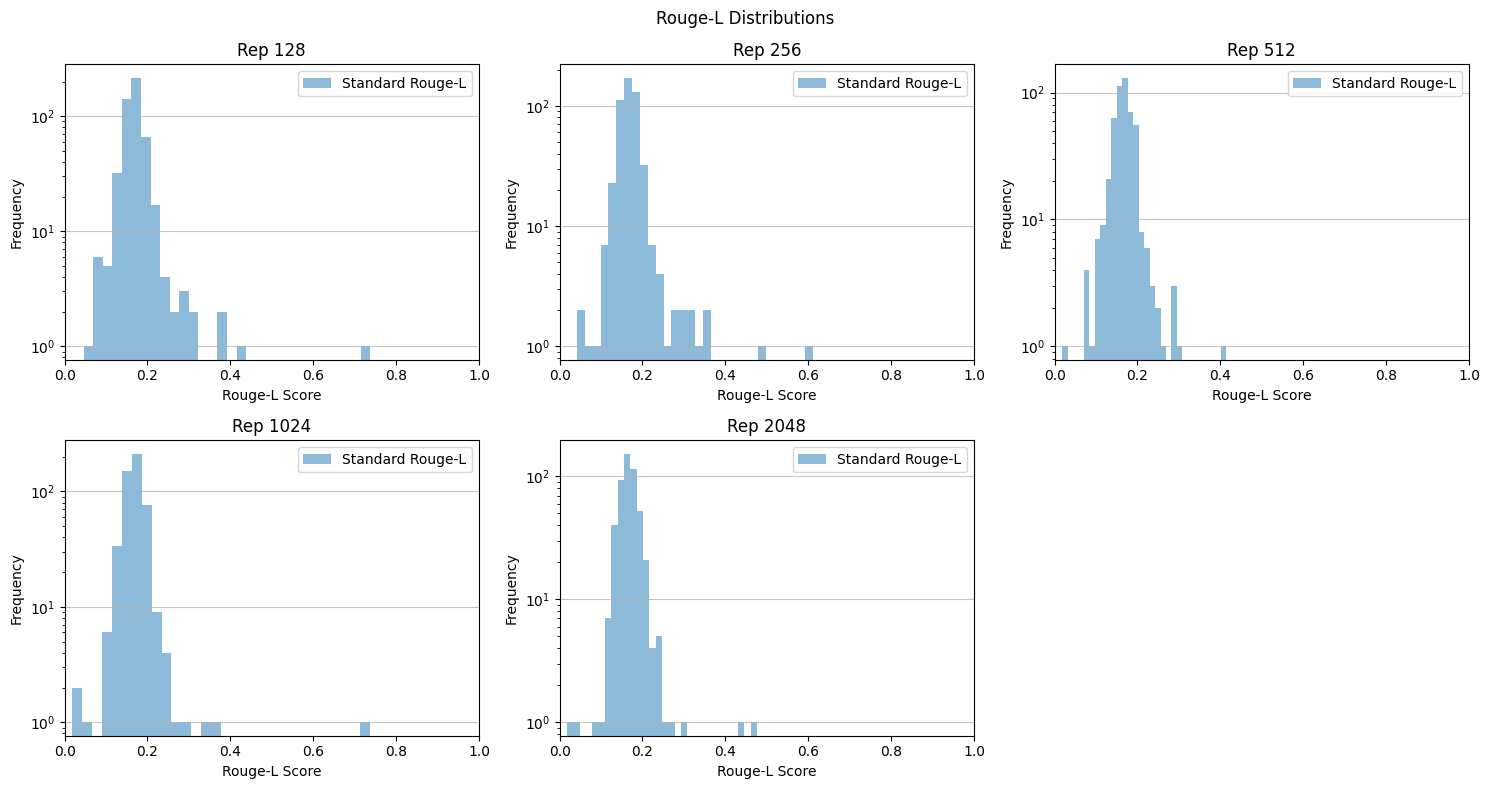

In [20]:
plot_ttr_dists(goldfish_res, repetitions_2048, metric='Rouge-L')

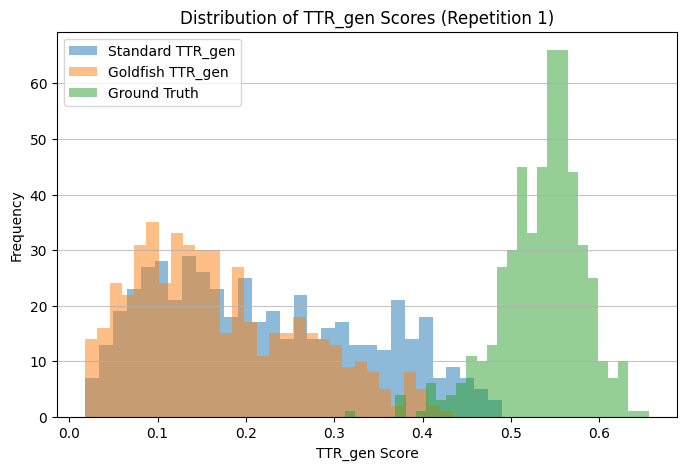

In [179]:
import matplotlib.pyplot as plt
import numpy as np

rep = 1
# Extract the scores
arr1 = goldfish_res['llama_1.5B_Sparse_Gutenberg_Standard_GBS_60'][rep]['TTR_gen']['scores']
arr2 = goldfish_res['llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60'][rep]['TTR_gen']['scores']
arr3 = goldfish_res['llama_1.5B_Sparse_Gutenberg_K_50_H_13_GBS_60'][rep]['TTR_ref']['scores']

# Plot histograms
plt.figure(figsize=(8, 5))
plt.hist(arr1, bins=30, alpha=0.5, label='Standard TTR_gen')
plt.hist(arr2, bins=30, alpha=0.5, label='Goldfish TTR_gen')
plt.hist(arr3, bins=30, alpha=0.5, label='Ground Truth')

plt.title(f"Distribution of TTR_gen Scores (Repetition {rep})")
plt.xlabel("TTR_gen Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()
